In [2]:
import h5py
import deepdish as dd
from convergenets.utils import utils
from scripts.visualizations.helpers import load_weights
from tqdm import tqdm
from tqdm import trange

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import itertools
import deepdish as dd
from scipy.stats import norm as sp_norm
from sklearn.linear_model import LinearRegression


In [3]:
CACHE_PATH = "/mnt/fs6/jvrsgsty/neural-mechanics/jv_neural_mechanics"

In [4]:
def phase_3d(ax, x, v, time, xt=None, vt=None, timet=None,
             k=None, color="k"):
    if k is None:
        k = len(x)
        assert k == len(v)
        assert k > 0
        min_x = min(x[-k:])
        min_v = min(v[-k:])
        max_time = max(time[-k:])
    
    if xt is not None:
        kt = len(xt)
        min_x = min(min_x, min(xt[-kt:]))
        min_v = min(min_v, min(vt[-kt:]))
        max_time = max(max_time, max(timet[-kt:]))
    
    # Empirical
    ax.plot(x[-k:], time, v[-k:], lw=1, color="k")
    ax.plot(x[-k:], time, min_v * np.ones(k), color="k", alpha=0.25)
    ax.plot(min_x * np.ones(k), time, v[-k:], color="k", alpha=0.25)
    ax.plot(x[-k:], max_time*np.ones(k), v[-k:], color="k", alpha=0.25)
    
    # Theory
    if xt is not None and vt is not None and timet is not None:
        ax.plot(xt[-kt:], timet, vt[-kt:], lw=1, color="r")
        ax.plot(xt[-kt:], timet, min_v * np.ones(kt), color="r", alpha=0.25)
        ax.plot(min_x * np.ones(kt), timet, vt[-kt:], color="r", alpha=0.25)
        ax.plot(xt[-kt:], max_time*np.ones(kt), vt[-kt:], color="r", alpha=0.25)
    
    # Labels
    ax.set_xlabel("Position")
    ax.set_ylabel("Time")
    ax.set_zlabel("Velocity")
    ax.view_init(elev=35.0, azim=-35)
    # This line just scales the axis in the figure: x,y,z,1.0 by the constants in the np.diag
    # Unsure why we have 0.75 in the last component
    ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 2, 1.5, 2]))
    #plt.tight_layout()
    # plt.savefig('bias-oscillations-3d.png', format='png', bbox_inches='tight', transparent=True)

In [5]:
def mean(eigenvalue, a_init, b_init, lr, beta, lamb, time):

    gamma = (1-beta)/(lr*(1+beta))
    omega = np.sqrt(2/(lr*(1+beta))*(eigenvalue+lamb))
    if np.isnan(gamma):
        raise "Gamma is NaN"
    if np.isnan(omega):
        raise "Omega is NaN"
    
    if gamma < omega:
        freq = np.sqrt(omega**2 - gamma**2)
        a = np.exp(-gamma*time)*(
            a_init*np.cos(freq*time) + 
            (gamma*a_init + b_init)/freq*np.sin(freq*time)
        )
        b = np.exp(-gamma*time)*(
            b_init*np.cos(freq*time) - 
            ((omega**2)*a_init+gamma*b_init)/freq*np.sin(freq*time)
        )

    if gamma == omega:
        a = np.exp(-gamma*time)*(a_init + (gamma*a_init + b_init)*time)
        b = np.exp(-gamma*time)*(b_init - ((omega**2)*a_init+gamma*b_init) * time)

    if gamma > omega:
        freq = np.sqrt(gamma**2 - omega**2)
        a = np.exp(-gamma*time)*(
            a_init*np.cosh(freq*time) + 
            (gamma*a_init + b_init)/freq*np.sinh(freq*time)
        )
        b = np.exp(-gamma*time)*(
            b_init*np.cosh(freq*time) - 
            ((omega**2)*a_init+gamma*b_init)/freq*np.sinh(freq*time)
        )

    return a, b

def variance(eigenvalue, confidence, sigma, lr, beta, lamb, bs, time):
    def matrix_exponential(gamma, omega, t):
        A = np.zeros((2,2))
        if gamma < omega:
            delta = np.sqrt(omega**2 - gamma**2)
            A[0,0] = np.cos(delta*t) + gamma/delta*np.sin(delta*t)
            A[0,1] = 1/delta*np.sin(delta*t)
            A[1,0] = -omega**2/delta*np.sin(delta*t)
            A[1,1] = np.cos(delta*t) - gamma/delta*np.sin(delta*t)
        if gamma == omega:
            A[0,0] = 1 + gamma*t
            A[0,1] = t
            A[1,0] = -omega**2 * t
            A[1,1] = 1 - gamma*t
        if gamma > omega:
            delta = np.sqrt(gamma**2 - omega**2)
            A[0,0] = np.cosh(delta*t) + gamma/delta*np.sinh(delta*t)
            A[0,1] = 1/delta*np.sinh(delta*t)
            A[1,0] = -omega**2/delta*np.sinh(delta*t)
            A[1,1] = np.cosh(delta*t) - gamma/delta*np.sinh(delta*t) 
        A *= np.exp(-gamma*t)
        return A
    gamma = (1-beta)/(lr*(1+beta))
    omega = np.sqrt(2/(lr*(1+beta))*(eigenvalue+lamb))
    Di = np.zeros((2,2))
    Di[0,0] = lr/(2*bs*(1-beta))*eigenvalue/(eigenvalue+lamb)
    Di[1,1] = 1/(bs*(1-beta**2))*eigenvalue
    z = sp_norm.interval(confidence)[1]
    va = []
    vb = []
    for t in time:
        A = matrix_exponential(gamma, omega, t)
        variance = Di - A.dot(Di).dot(A.T)
        try:
            L = np.linalg.cholesky(variance)
        except np.linalg.LinAlgError:
            L = np.zeros_like(variance)
        va.append(L.dot(np.array([z,0]))[0])
        vb.append(L.dot(np.array([0,z]))[1])
    va = sigma**2 * np.array(va)
    vb = sigma**2 * np.array(vb)
    return va, vb

In [6]:
def load_cache(experiment="hessian", expid="imagenet_pret_ce", expid_eigenvalues=None, **kwargs):
    if expid_eigenvalues is None:
        expid_eigenvalues = expid
    PT_CACHE_DIR = "/mnt/fs6/jvrsgsty/neural-mechanics"
    traj_cache = f"{PT_CACHE_DIR}/{experiment}/{expid}/cache/pos_vel.h5"
    weights = dd.io.load(traj_cache, f"/metrics/position")
    grads = dd.io.load(traj_cache, f"/metrics/velocity")
    spectral_cache = f"{PT_CACHE_DIR}/{experiment}/{expid_eigenvalues}/metrics/spectral.h5"
    eigenvectors = dd.io.load(spectral_cache, f"/eigenvector")
    eigenvalues = dd.io.load(spectral_cache, f"/eigenvalues")
    eigen_idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[eigen_idx]
    eigenvectors = eigenvectors[:,eigen_idx]
    assert weights.shape == grads.shape
    assert weights.shape[1] == eigenvectors.shape[0]
    return weights, grads, eigenvectors, eigenvalues
    
def project(weights, grads, eigenvectors,eig_idx = 0): 
    projected_weights = np.array(
        [np.dot(weights[i], eigenvectors[:, eig_idx]) for i in range(weights.shape[0])]
    )
    projected_grads = np.array(
        [np.dot(grads[i], eigenvectors[:, eig_idx]) for i in range(grads.shape[0])]
    )
    return projected_weights, projected_grads


In [7]:
def load_cache_new(experiment="hessian", expid="imagenet_pret_ce", subdir="", suffix=""):
    PT_CACHE_DIR = f"/mnt/fs6/jvrsgsty/neural-mechanics{subdir}"
    cache_dir = f"{PT_CACHE_DIR}/{experiment}/{expid}/cache/hessian_eigenprojection{suffix}.h5"
    projected_weights = dd.io.load(cache_dir, f"/projected_weights")
    projected_grads = dd.io.load(cache_dir, f"/projected_grads")
    eigenvectors = dd.io.load(cache_dir, f"/eigenvectors")
    eigenvalues = dd.io.load(cache_dir, f"/eigenvalues")
    return projected_weights, projected_grads, eigenvectors, eigenvalues


In [8]:
def plot_moving_average(ax, x, y, w=5, **plot_kwargs):
    moving_average = np.convolve(y, np.ones(w), 'valid') / w
    ax.plot(x[(w-1)//2:-(w-1)//2], moving_average, **plot_kwargs)
    plot_kwargs["alpha"] = 0.5
    ax.plot(x, y, **plot_kwargs)

In [62]:
def style_axes(ax, numyticks=5, numxticks=5):
    ax.tick_params(axis="y", which="both", bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True,direction='out',length=7,width=1.5,pad=8,labelsize=24)
    ax.yaxis.set_major_locator(plt.MaxNLocator(numyticks))
    
    ax.tick_params(axis="x", which="both", bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True,direction='out',length=7,width=1.5,pad=8,
                   labelsize=24)
    ax.xaxis.set_major_locator(plt.MaxNLocator(numxticks))
    #ax.ticklabel_format(axis="x", style="scientific", scilimits=(0,0), useMathText=True)
    ax.ticklabel_format(axis="x", useMathText=True)
    ax.xaxis.offsetText.set_fontsize(20)

    # boundary
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
    for dir in ["top", "bottom", "right", "left"]:
        ax.spines[dir].set_linewidth(3)

# Figure 1

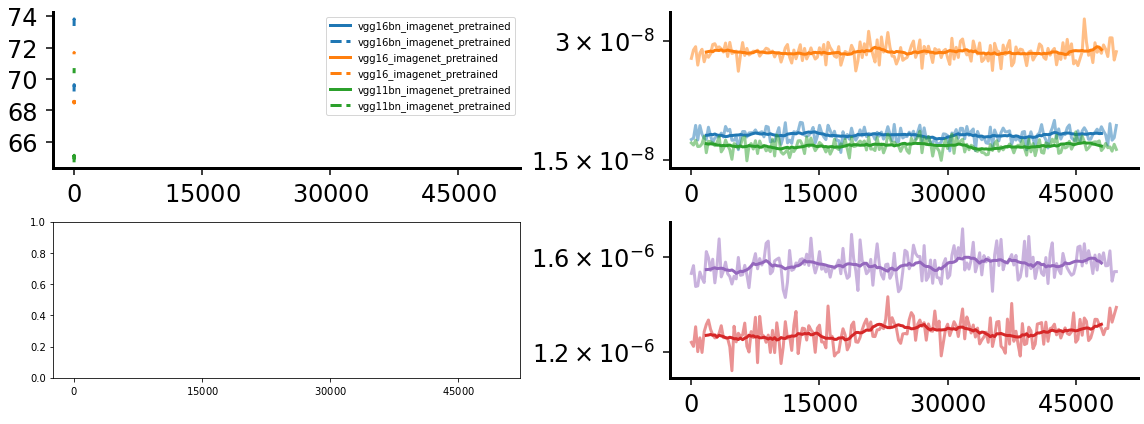

In [54]:
nrows = 2
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(8 * ncols, 3 * nrows), sharex=True)

CACHE_PATH = "/mnt/fs6/jvrsgsty/neural-mechanics/jv_neural_mechanics"
experiment = "fig_1"
expids = [
    #"alexnet_imagenet_pretrained",
    "vgg16bn_imagenet_pretrained",
    "vgg16_imagenet_pretrained",
    "vgg11bn_imagenet_pretrained",
    #"res18_imagenet_pretrained",
    #"res34_imagenet_pretrained",
]
lrs = [0.00001, 0.00001, 0.00001]
for i,expid in enumerate(expids):
    d = dd.io.load(f"{CACHE_PATH}/{experiment}/{expid}/cache/performance_from_ckpt.h5", "/performance")
    ax = axes[0,0]
    plot_kwargs = {"label":expid, "color": plt.cm.tab10(i), "lw": 3}
    d["train_batch_accuracy1"] = 100.0*d["train_batch_accuracy1"]/32.
    ax.plot(np.linspace(1, 10, len(d["train_accuracy1"])), d["train_accuracy1"], **plot_kwargs)
    ax.plot(np.linspace(1, 10, len(d["test_accuracy1"])), d["test_accuracy1"], ls="--", **plot_kwargs)
    #plot_moving_average(axes[0], np.linspace(1, 10, len(d["train_batch_accuracy1"])), 
    #                    d["train_batch_accuracy1"], w=50, **plot_kwargs)
    #axes[0].plot([100]*len(d["train_accuracy1"]), color="k", ls="--")
    ax.legend()
    #axes[0].set_ylim([99, 101])
    #axes[0].set_title("Accuracy")
    #axes[0].set_ylabel("Accuracy")
    #axes[0].set_xlabel("Train epoch")
    style_axes(ax)
    
    ax = axes[0,1]
    d = dd.io.load(f"{CACHE_PATH}/{experiment}/{expid}/cache/loss_diff_from_ckpt.h5", "/loss_diff")
    plot_kwargs = {"label":expid, "color": plt.cm.tab10(i), "lw": 3}
    plot_moving_average(ax, np.arange(len(d["vel_norm"]))*250, (lrs[i]**2)*d["vel_norm"], w=15, **plot_kwargs)
    #axes[1].legend()
    ax.set_yscale("log")
    style_axes(ax, numyticks=1)
    ax.yaxis.set_minor_locator(plt.MaxNLocator(1))
    
expids = [
    "res18_imagenet_pretrained",
    "res34_imagenet_pretrained",
]
lrs = [0.0001, 0.0001]
for i,expid in enumerate(expids):
    ax = axes[1,1]
    d = dd.io.load(f"{CACHE_PATH}/{experiment}/{expid}/cache/loss_diff_from_ckpt.h5", "/loss_diff")
    plot_kwargs = {"label":expid, "color": plt.cm.tab10(i+3), "lw": 3}
    plot_moving_average(ax, np.arange(len(d["vel_norm"]))*250, (lrs[i]**2)*d["vel_norm"], w=15, **plot_kwargs)
    #axes[1].legend()
    ax.set_yscale("log")
    style_axes(axes[1,1], numyticks=1)
    ax.yaxis.set_minor_locator(plt.MaxNLocator(1))
plt.tight_layout()
plt.savefig("fig_1_sq.pdf")

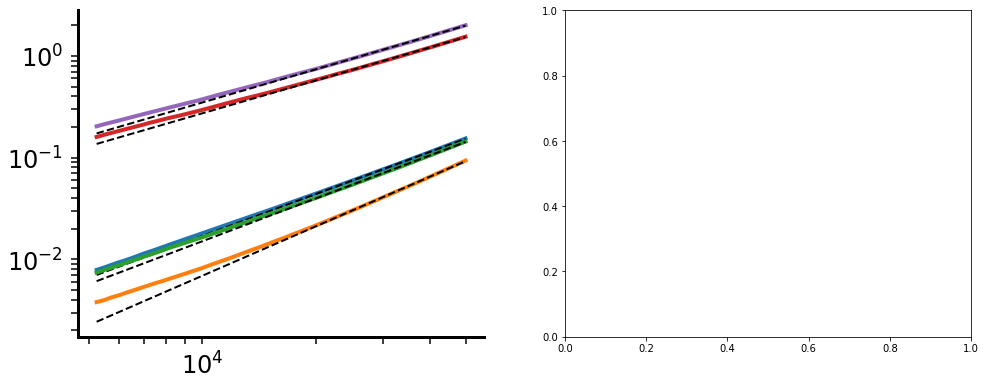

In [150]:
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(8 * ncols, 6 * nrows))

CACHE_PATH = "/mnt/fs6/jvrsgsty/neural-mechanics/jv_neural_mechanics"
experiment = "fig_1"
expids = [
    #"alexnet_imagenet_pretrained",
    "vgg16bn_imagenet_pretrained",
    "vgg16_imagenet_pretrained",
    "vgg11bn_imagenet_pretrained",
    "res18_imagenet_pretrained",
    "res34_imagenet_pretrained",
]
lr = 0.1
coords = [(0.5,-2.5),(0,1),(-3,-6.5),(-1,-3.5),(0,0)]
coords = [np.exp(c) for c in coords]
for i,expid in enumerate(expids):
    d = dd.io.load(
        f"{CACHE_PATH}/{experiment}/{expid}/cache/dist_from_start_from_ckpt.h5", 
        "/dist_from_start"
    )
    x = np.arange(len(d["dist_from_start"]))*250
    y = d["dist_from_start"]**2
    x = np.log(x[21:]) # skip the first epoch
    y = np.log(y[21:]) # skip the first epoch
    
    x_ = x[len(x)//3:] # fit on the last 2/3 of data
    y_ = y[len(y)//3:] # fit on the last 2/3 of data
    model = LinearRegression()
    model.fit(x_[:, np.newaxis], y_)

    x_fit = np.linspace(min(x), max(x), 100)
    y_fit = model.predict(x_fit[:, np.newaxis])
    
    # Transform back to normal coordinates, but still plot on loglog
    x = np.exp(x)
    y = np.exp(y)
    x_fit = np.exp(x_fit)
    y_fit = np.exp(y_fit)
    ax = axes[0]
    ax.plot(x, y, 
                 label=f"{expid} fit slope: {model.coef_[0]:1.3f}", color=plt.cm.tab10(i),
                 lw=4)
    ax.plot(x_fit, y_fit, "k--",
                 lw=2)
    ax.set_yscale("log")
    ax.set_xscale("log")
    #axes[0].text(coords[i][0], coords[i][1], f"c={model.coef_[0]:1.3f}", color=plt.cm.tab10(i),
    #            size=22)
    #axes[0].set_title("log-log squared distance from pretrained")
    #axes[0].set_ylabel("log(|W_0 - W_t|_2^2)")
    #axes[0].set_xlabel("log(Epochs from pretained state)")
    #axes[0].set_yscale("log")
    #axes[0].legend()
    
    ax.tick_params(axis="y", which="both", bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True,direction='out',length=7,width=1.5,pad=8,labelsize=24)
    
    ax.tick_params(axis="x", which="both", bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True,direction='out',length=7,width=1.5,pad=8,
                   labelsize=24)

    # boundary
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False) 
    for dir in ["top", "bottom", "right", "left"]:
        ax.spines[dir].set_linewidth(3)
    
plt.savefig("fig_1_Delta.pdf")

# Figure 2

In [10]:
def phase_3d_polished(ax, x, v, time, xt=None, vt=None, timet=None, w=None, color="k"):
    min_x = min(x)
    min_v = min(v)
    max_time = max(time)
    
    if w is not None:
        noisy_x = x[(w-1)//2:-(w-1)//2]
        noisy_v = v[(w-1)//2:-(w-1)//2]
        time = time[(w-1)//2:-(w-1)//2]
        x = np.convolve(x, np.ones(w), "valid") / w
        v = np.convolve(v, np.ones(w), "valid") / w
        
    k = len(x)
    if xt is not None:
        kt = len(xt)
    
    # Empirical
    ax.plot(x, time, v, lw=2, color="k")
    ax.plot(x, time, min_v * np.ones(k), color="k", alpha=0.4) # position projection
    ax.plot(min_x * np.ones(k), time, v, color="k", alpha=0.4) # velocity projection
    #ax.plot(x[-k:], max_time*np.ones(k), v[-k:], color="k", alpha=0.25) # Phase portrait
    if w is not None:
        ax.plot(noisy_x, time, min_v * np.ones(k), color="k", alpha=0.2, lw=2) # position projection
        ax.plot(min_x * np.ones(k), time, noisy_v, color="k", alpha=0.2, lw=2) # velocity projection
    
    # Theory
    if xt is not None and vt is not None and timet is not None:
        ax.plot(xt, timet, vt, lw=1, color="r")
        ax.plot(xt, timet, min_v * np.ones(kt), color="r", alpha=0.25)
        ax.plot(min_x * np.ones(kt), timet, vt, color="r", alpha=0.25)
        #ax.plot(xt, max_time*np.ones(kt), vt, color="r", alpha=0.25)
    
    # Labels
    #ax.set_xlabel("Position")
    #ax.set_ylabel("Time")
    #ax.set_zlabel("Velocity")
    ax.view_init(elev=35.0, azim=-45)
    # This line just scales the axis in the figure: x,y,z,1.0 by the constants in the np.diag
    # Unsure why we have 0.75 in the last component
    ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 2, 1.5, 2]))
    
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    
    ax.zaxis.set_tick_params(which="both", reset=True, bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True, direction='out',length=7,width=1.5,pad=8,
                   labelsize=18)
    ax.zaxis.set_major_locator(plt.MaxNLocator(5))
    
    ax.yaxis.set_tick_params(which="both", reset=True, bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True, direction='out',length=7,width=1.5,pad=5,
                   labelsize=18)
    ax.yaxis.set_major_locator(plt.MaxNLocator(8))
    
    ax.xaxis.set_tick_params(which="both", reset=True,
                   labelbottom=True,
                   labelleft=True, direction='out',length=100,width=20,pad=5,
                   labelsize=18)
    ax.xaxis.set_major_locator(plt.MaxNLocator(4))
    
    
    # boundary
    for axs in [ax.w_xaxis, ax.w_yaxis, ax.w_zaxis]:
        axs.line.set_linewidth(3)


    #plt.tight_layout()
    # plt.savefig('bias-oscillations-3d.png', format='png', bbox_inches='tight', transparent=True)

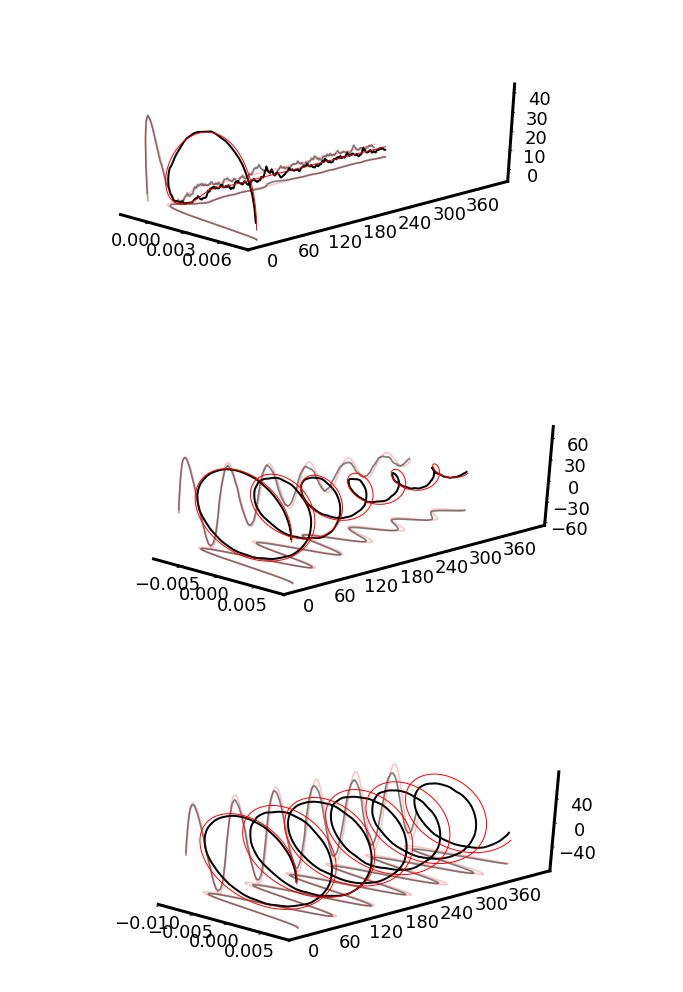

In [163]:
nrows = 3
ncols = 1
l = -2000
k = -1
w = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(12 * ncols, 6 * nrows), subplot_kw={"projection":"3d"})

lr = 1e-5
wd = 0
bs = 512
momentums = [0.9, 0.99, 0.999]
eig_idx = 0
for i, momentum in enumerate(momentums):
    lr_= f"{lr:1.0e}".replace("-","n")
    wd_= f"{wd:1.0e}".replace("-","n") if wd > 0 else "0"
    mom_ = f"{momentum}".replace(".", "")
    expid = f"cifar10_hessian_lr{lr_}_wd{wd_}_bs{bs}_mom{mom_}"
    weights, grads, eigenvectors, eigenvalues = load_cache(
        expid_eigenvalues="cifar10_hessian_evals", experiment="linear_regression", expid=expid,
    )
    
    projected_weights, projected_grads = project(weights, grads, eigenvectors, eig_idx)
    
    steps = np.arange(0, projected_weights.shape[0])
    
    time = lr*np.linspace(0,projected_weights.shape[0],10000)
    mu = np.mean(projected_weights[-100:], axis=0)
    a0 = (projected_weights[0] - mu)
    a, b = mean(eigenvalues[eig_idx], a0, 0, lr, momentum, wd, time)
    b*= -1
    a += mu
    
    sigma = 0.8
    va, vb = variance(eigenvalues[eig_idx], 0.95, sigma, lr, momentum, wd, bs, time)
    
    ax = axes[i]
    phase_3d_polished(
        ax, x=projected_weights[l:k], v=projected_grads[l:k], time=np.arange(len(projected_grads[l:k])), 
        xt=a, vt=b, timet=np.linspace(0,projected_weights.shape[0],10000), 
        w=w)
plt.savefig("spirals_linear_regression.pdf")  

# Figure 3

In [11]:
def style_heatmaps(ax, ylabels=True):
    ax.tick_params(axis="x", which="both", bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True, direction='out',length=7,width=1.5,pad=0,
                   labelsize=24,labelrotation=45)
    ax.xaxis.set_major_locator(plt.MaxNLocator(6))
    if ylabels:
        ax.tick_params(axis="y", which="both", bottom=True, top=False,
                   labelbottom=True, left=True, right=False,
                   labelleft=True, direction='out',length=7,width=1.5,pad=4,
                   labelsize=24)   
        ax.yaxis.set_major_locator(plt.MaxNLocator(6))
    else:
        ax.tick_params(axis="y", which="both", bottom=True, top=False,
                   labelbottom=False, left=True, right=False,
                   labelleft=False, direction='out',length=7,width=1.5,pad=4,
                   labelsize=24)
        ax.set_ylabel("")

    ax.xaxis.offsetText.set_fontsize(20)

    # boundary
    for dir in ["top", "bottom", "right", "left"]:
        ax.spines[dir].set_linewidth(3)

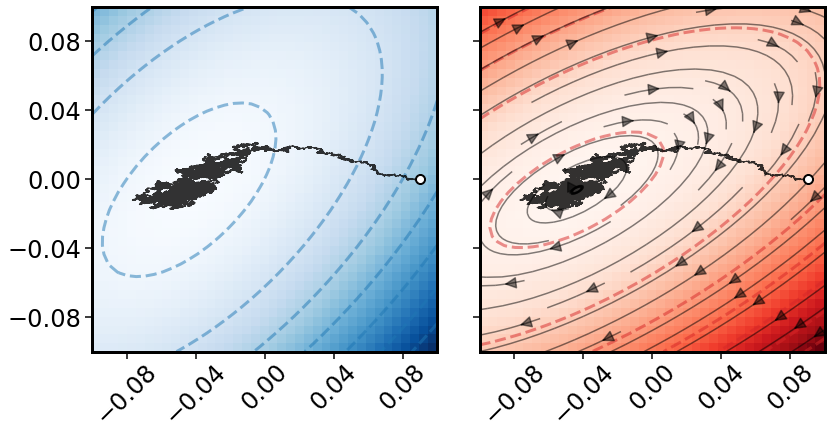

In [39]:
def get_Q(V, V_inv, Sigma, D):
    D = V.dot(D).dot(V_inv)
    Q = np.zeros_like(D)
    for i in range(2):
        for j in range(2):
            Q[i,j] = D[i,j] * (Sigma[i] - Sigma[j]) / (Sigma[i] + Sigma[j])
    Q = V_inv.dot(Q).dot(V)
    return Q

def get_U(A, D, Q):
    B = np.linalg.inv(D + Q)
    U = B.dot(A)
    return U

def SDE(x10, x20, num_steps, eta, A, b, D):
    x1 = [x10]
    x2 = [x20]
    L = np.linalg.cholesky(D)
    for i in range(num_steps):
        xi = L.dot(np.random.normal(0, eta, 2))
        g1 = eta * (A[0,0] * x1[-1]  +  A[0,1] * x2[-1] - b[0]) + xi[0]
        g2 = eta * (A[1,0] * x1[-1]  +  A[1,1] * x2[-1] - b[1]) + xi[1]
        x1.append(x1[-1] - g1)
        x2.append(x2[-1] - g2)
    return x1, x2

Sigma = np.array([4,1])
V = np.array([[-1,1],[1,1]])
V_inv = np.linalg.inv(V)
A = V_inv.dot(np.diag(Sigma)).dot(V)
b = np.array([-0.1,0.05])
D = np.array([[4,0],[0,1]])
Q = get_Q(V, V_inv, Sigma, D)
U = get_U(A, D, Q)
u = U.dot(np.linalg.inv(A)).dot(b)
n = 0.1
x10 = 0.09
x20 = 0
num_steps=100000
eta = 1e-4
x1, x2 = SDE(x10, x20, num_steps, eta, A, b, D)
X1, X2 = np.meshgrid(np.linspace(-n, n, 40), np.linspace(-n, n, 40))
Phi = 0.5 * (A[0,0] * X1**2 + (A[0,1] + A[1,0])*X1*X2 + A[1,1] * X2**2) - b[0] * X1 - b[1] * X2
Psi = 0.5 * (U[0,0] * X1**2 + (U[0,1] + U[1,0])*X1*X2 + U[1,1] * X2**2) - u[0] * X1 - u[1] * X2

nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 6 * nrows), sharey=True)

ax = axes[0]
ax.set_aspect('equal', 'box')
ax.set_xlim([-n, n])
ax.set_ylim([-n, n])
ax.plot(x1, x2, color='k', alpha=0.8, lw=1)
ax.contour(X1, X2, Phi, colors=[plt.cm.tab10(0)], alpha=0.5, linestyles='dashed', linewidths=3)
ax.pcolormesh(X1, X2, Phi, cmap='Blues')
ax.plot(x10, x20, "o", color="k", lw=2, markersize=10)
ax.plot(x10, x20, "o", color="w", lw=2, markersize=6)
style_heatmaps(ax)

ax = axes[1]
ax.set_aspect('equal', 'box')
ax.set_xlim([-n, n])
ax.set_ylim([-n, n])
ax.plot(x1, x2, color='k', alpha=0.8, lw=1)
ax.contour(X1, X2, Psi, colors=[plt.cm.tab10(3)], alpha=0.5, linestyles='dashed', linewidths=3)
ax.pcolormesh(X1, X2, Psi, cmap='Reds')
ax.plot(x10, x20, "o", color="k", lw=2, markersize=10)
ax.plot(x10, x20, "o", color="w", lw=2, markersize=6)
QU = Q.dot(U)
Du_b = -Q.dot(u)
J1 = QU[0,0] * X1 + QU[0,1] * X2 + Du_b[0]
J2 = QU[1,0] * X1 + QU[1,1] * X2 + Du_b[1]
ax.streamplot(X1, X2, J1, J2, color=(0,0,0,0.5), arrowsize=2.5, density=0.75)
style_heatmaps(ax, ylabels=False)
plt.tight_layout()
plt.savefig('OU.pdf')

# Figure 4 and 5

In [178]:
def bounding_box(x_i, x_j):
    half_length = max(max(x_j)-min(x_j), max(x_i)-min(x_i))/2 * 1.2
    mid_j = (max(x_j)+min(x_j)) / 2
    mid_i = (max(x_i)+min(x_i)) / 2
    x_min = mid_i - half_length
    x_max = mid_i + half_length
    y_min = mid_j - half_length
    y_max = mid_j + half_length
    return x_min, x_max, y_min, y_max

def large_bounding_box_origin(x_i, x_j):
    half_length = max(max(x_j)-min(x_j), max(x_i)-min(x_i))/2 * 2
    mid_j = x_j[0]
    mid_i = x_i[0]
    x_min = mid_i - half_length
    x_max = mid_i + half_length
    y_min = mid_j - half_length
    y_max = mid_j + half_length
    return x_min, x_max, y_min, y_max

def plot_position_traj_with_heatmap(ax, x_i, x_j, lr, momentum, wd, eigenvalue_i, eigenvalue_j, 
                                    bias_i=0, bias_j=0, traj_alpha=0.5):
    #mu_i = np.mean(x_i)
    #mu_j = np.mean(x_j)
    mu_i = x_i[0] - bias_i
    mu_j = x_j[0] - bias_j
    
    x_min, x_max, y_min, y_max = large_bounding_box_origin(x_i, x_j)
    y_min += 0.0001
    y_max -= 0.0001
    
    X_i, X_j = np.meshgrid(np.linspace(x_min, x_max, 40), 
                         np.linspace(y_min, y_max, 40))
    
    scale_i = 1/(lr * (1 + momentum)) * (1 + wd / eigenvalue_i)
    scale_j = 1/(lr * (1 + momentum)) * (1 + wd / eigenvalue_j)

    Psi = scale_i*(X_i - mu_i)**2 + scale_j*(X_j - mu_j)**2

    ax.contour(X_i, X_j, Psi, colors=[plt.cm.tab10(3)], alpha=0.5, linestyles='dashed', linewidths=3)
    ax.pcolormesh(X_i, X_j, Psi, cmap='Reds')
    
    ax.plot(x_i, x_j, color="k", alpha=traj_alpha)
    ax.scatter(x_i[0], x_j[0], color='w', zorder=120, s=200, edgecolors='k', linewidth=3)

    #ax.axis('equal')
    ax.set_aspect('equal', 'box')
    ax.set_xlim((x_min, x_max))
    ax.set_ylim((y_min, y_max))

def plot_velocity_traj_with_heatmap(ax, x_i, x_j, eigenvalue_i, eigenvalue_j):
    x_min, x_max, y_min, y_max = bounding_box(x_i, x_j)
    
    
    #X_i, X_j = np.meshgrid(np.linspace(x_min-0.05, x_max+0.05, 40), 
    #                     np.linspace(y_min-0.1, y_max+0.1, 40))
    X_i, X_j = np.meshgrid(np.linspace(x_min, x_max, 40), 
                         np.linspace(y_min, y_max, 40))

    scale_i = 1/eigenvalue_i
    scale_j = 1/eigenvalue_j

    Psi = scale_i*(X_i)**2 + scale_j*(X_j)**2

    ax.contour(X_i, X_j, Psi, colors=[plt.cm.tab10(3)], alpha=0.5, linestyles='dashed', linewidths=3)
    ax.pcolormesh(X_i, X_j, Psi, cmap='Reds')
    
    ax.plot(x_i, x_j, color="k", alpha=0.5)
    ax.scatter(x_i[0], x_j[0], color='w', zorder=120, s=200, edgecolors='k', linewidth=3)

    #ax.axis('equal')
    ax.set_aspect('equal', 'box')
    ax.set_xlim((x_min, x_max))
    ax.set_ylim((y_min, y_max))

In [14]:
def plot_position_traj_empirics(ax, x_i, x_j, Psi, traj_alpha=0.5):
    x_min, x_max, y_min, y_max = large_bounding_box_origin(x_i, x_j)

    ## Empirics
    ax.plot(x_i, x_j, color="k", alpha=traj_alpha)
    ax.scatter(x_i[0], x_j[0], color='w', zorder=120, s=200, edgecolors='k', linewidth=3)
    
    if Psi is not None:
        X, Y = np.meshgrid(np.linspace(x_min, x_max, 40), 
                           np.linspace(y_min, y_max, 40))

        ax.contour(X, Y, Psi, colors=[plt.cm.tab10(0)], alpha=0.5, linestyles='dashed', linewidths=3)
        ax.pcolormesh(X, Y, Psi, cmap='Blues')
    #ax.axis("equal")
    ax.set_aspect('equal', 'box')
    ax.set_xlim((x_min, x_max))
    ax.set_ylim((y_min, y_max))

In [165]:
# Assemble grid from individual files, figure out missing
num_rows = 40
num_cols = 40
experiment = "loss_grid"
#expid = f"res18_40x40"
#expid = f"res18_40x40_single"
#expid = f"res18_40x40_square_notransform"
#expid = f"res18_40x40_square_notransform_eval"
#expid = f"res18_40x40_final"
#expid = f"res18_40x40_origin_deterministic_loader"
expid = f"res18_40x40_origin"
load_path = f"{CACHE_PATH}/{experiment}/{expid}/grid"

train_loss = np.ones((num_rows, num_cols))*1.31981858
test_loss = np.ones((num_rows, num_cols))*1.24773066
train_acc = np.ones((num_rows, num_cols))*78.968
test_acc = np.ones((num_rows, num_cols))*69.664
missing = []
for x in range(num_rows):
    for y in range(num_cols):
        try:
            d = dd.io.load(f"{load_path}/{x}_{y}.h5")
            train_loss[x,y] = d["train_loss"]
            #if train_loss[x,y] < 1.31:
                #train_loss[x,y] = 1.31691543
            test_loss[x,y] = d["test_loss"]
            train_acc[x,y] = d["train_top1"]
            test_acc[x,y] = d["test_top1"]
        except:
            missing.append((x,y))
            print("Missing entry ", x, y)
        

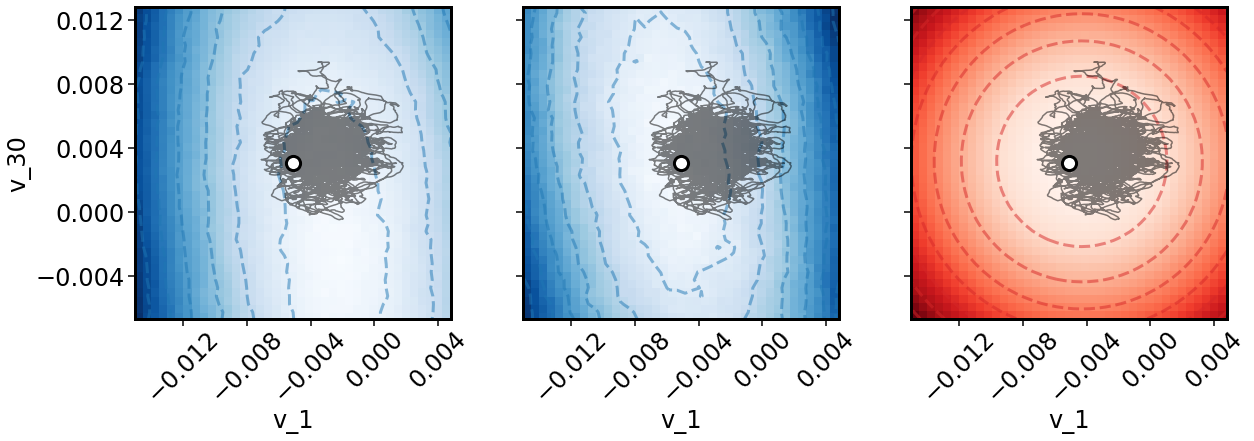

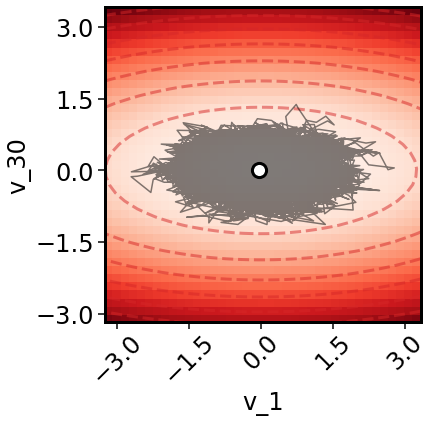

In [179]:
# visualize pos and vel
eig_idxs = [0,29]
lr = 1e-5
momentum = 0.9
wd = 1e-4

experiment = "pretrained_imagenet"
expid = f"rest18_pretrained_initial_30evals_40k"
d = dd.io.load(f"{CACHE_PATH}/{experiment}/{expid}/metrics/spectral.h5")
eigenvalues = d["eigenvalues"]
eigenvectors = d["eigenvector"]

experiment = "loss_grid"
expid = f"res18_gradient_subset"
grad = dd.io.load(f"{CACHE_PATH}/{experiment}/{expid}/metrics/spectral.h5", "/gradient")
projected_grad = eigenvectors.T @ grad.cpu().numpy()
bias_29 = projected_grad[29]/eigenvalues[29]
bias_0 = projected_grad[0]/eigenvalues[0]

experiment = "loss_grid"
expid = f"trajectory_5epochs"
expid = f"trajectory_5epochs_nojitter"# val performance: 69.30, _ , _ , 69.68, 69.58 , 70 
d = dd.io.load(f"{CACHE_PATH}/{experiment}/{expid}/cache/dist_from_start_from_ckpt.h5", "/dist_from_start")
projected_weights = d["projected_pos"]
projected_grads = d["projected_vel"]
x_i = projected_weights[:,0]
x_j = projected_weights[:,29]

###############################
nrows = 1
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 6 * nrows), sharey=True)
#ax = axes[0]
#plot_position_traj_empirics(ax, x_i, x_j, None,traj_alpha=0.8)
#ax.set_xlabel("v_1", size=24)
#ax.set_ylabel("v_30", size=24)
#style_heatmaps(ax, ylabels=True)
##plt.tight_layout()
##plt.savefig("position.pdf")

#fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 6 * nrows))
ax = axes[0]
plot_position_traj_empirics(ax, x_i, x_j, train_loss.T, traj_alpha=0.5)
ax.set_xlabel("v_1", size=24)
ax.set_ylabel("v_30", size=24)
style_heatmaps(ax, ylabels=True)
#plt.tight_layout()
#plt.savefig("position_train.pdf")

#fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 6 * nrows))
ax = axes[1]
plot_position_traj_empirics(ax, x_i, x_j, test_loss.T, traj_alpha=0.5)
ax.set_xlabel("v_1", size=24)
ax.set_ylabel("v_30", size=24)
style_heatmaps(ax, ylabels=False)
#plt.tight_layout()
#plt.savefig("position_test.pdf")

#fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 6 * nrows))
ax = axes[2]
plot_position_traj_with_heatmap(ax, x_i, x_j, lr, momentum, wd, eigenvalues[0], eigenvalues[29], 
                                bias_0, bias_29, traj_alpha=0.5)
ax.set_xlabel("v_1", size=24)
ax.set_ylabel("v_30", size=24)
style_heatmaps(ax, ylabels=False)
plt.tight_layout()
#plt.savefig("position_theory.pdf")
plt.savefig("position_row.pdf")

nrows = 1
ncols = 1
fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 6 * nrows))
x_i = projected_grads[:,0]
x_j = projected_grads[:,29]
plot_velocity_traj_with_heatmap(axes, x_i, x_j, eigenvalues[0], eigenvalues[29])
style_heatmaps(axes)
axes.set_xlabel("v_1", size=24)
axes.set_ylabel("v_30", size=24)
plt.tight_layout()
plt.savefig("velocity_theory.png")

# Figure 6

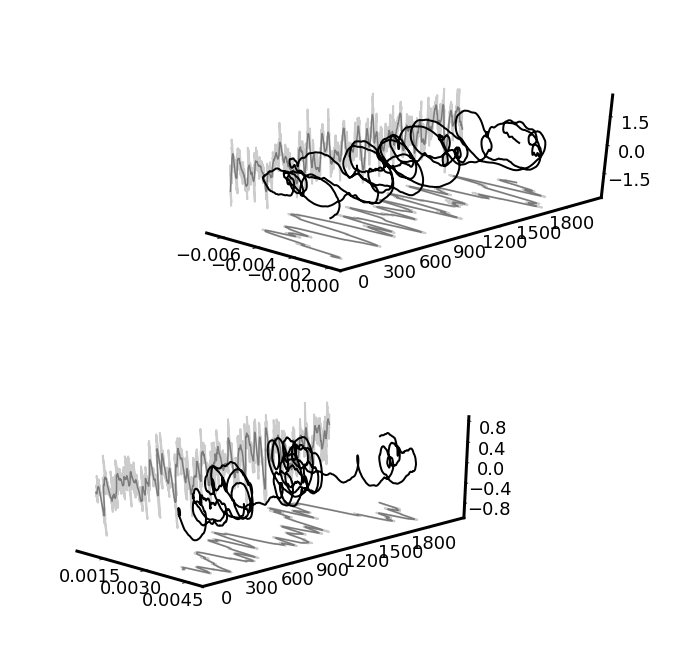

In [24]:
nrows = 2
ncols = 1
l = -2000
k = -1
w = 20
fig, axes = plt.subplots(nrows, ncols, figsize=(12 * ncols, 6 * nrows), subplot_kw={"projection":"3d"})
phase_3d_polished(axes[0], x=projected_weights[l:k,0], v=projected_grads[l:k,0], 
         time=range(len(projected_grads[l:k,0])), w=w)
phase_3d_polished(axes[1], x=projected_weights[l:k,29], v=projected_grads[l:k,29], 
         time=range(len(projected_grads[l:k,29])), w=w)
plt.savefig("spirals.pdf")

# Figure 7

In [157]:
lr = 0.0001
wd = 0.0001
bs = 256
momentum = 0.9
lrs = np.linspace(1e-3, 1e-5, 20)
experiment = "lean_sweep_3"
lr_deltas = []
lr_Delta_slopes = []
lr_Delta_intercepts = []
lr_performance = []
for i,lr in enumerate(lrs):
    lr_= f"{lr:1.0e}".replace("-","n")
    lr_= f"{lr:1.2e}".replace("-","n").replace(".","d")
    wd_= f"{wd:1.0e}".replace("-","n") if wd > 0 else "0"
    mom_ = f"{momentum}".replace(".", "")
    expid = f"res18_lr{lr_}_wd{wd_}_mom{mom_}_bs{bs}"
    d = dd.io.load(f"{CACHE_PATH}/{experiment}/{expid}/cache/loss_diff_from_ckpt.h5", "/loss_diff")
    lr_deltas.append((lr**2)*d["vel_norm"][-1])
    
    d = dd.io.load(f"{CACHE_PATH}/{experiment}/{expid}/cache/performance_from_ckpt.h5", "/performance")
    steps = d["step"][2:-1]
    
    d = dd.io.load(f"{CACHE_PATH}/{experiment}/{expid}/cache/dist_from_start_from_ckpt.h5", "/dist_from_start")
    x = steps
    y = d["dist_from_start"]**2
    x = np.log(x[1:])#[k:]
    #x = np.log(np.arange(1, -k+1))
    y = np.log(y[1:])#[k:]
    
    x_ = x#[len(x)//2:]
    y_ = y#[len(y)//2:]
    
    model = LinearRegression()
    model.fit(x_[:, np.newaxis], y_)

    x_fit = np.linspace(min(x), max(x), 100)
    y_fit = model.predict(x_fit[:, np.newaxis])
    
    lr_Delta_slopes.append(model.coef_[0])
    lr_Delta_intercepts.append(model.intercept_)
    d = dd.io.load(f"{CACHE_PATH}/{experiment}/{expid}/cache/performance_from_ckpt.h5", "/performance")
    performance = d["test_loss"][-1]
    lr_performance.append(performance)

In [158]:
lr = 0.0001
wd = 0.0001
bs = 256
momentum = 0.9
bss = np.linspace(32, 1024, 20)
bss = np.array([int(bs) for bs in bss])
experiment = "lean_sweep_3"
bs_deltas = []
bs_Delta_slopes = []
bs_Delta_intercepts = []
bs_performance = []
for i,bs in enumerate(bss):
    lr_= f"{lr:1.0e}".replace("-","n")
    lr_= f"{lr:1.2e}".replace("-","n").replace(".","d")
    wd_= f"{wd:1.0e}".replace("-","n") if wd > 0 else "0"
    mom_ = f"{momentum}".replace(".", "")
    expid = f"res18_lr{lr_}_wd{wd_}_mom{mom_}_bs{bs}"
    d = dd.io.load(f"{CACHE_PATH}/{experiment}/{expid}/cache/loss_diff_from_ckpt.h5", "/loss_diff")
    bs_deltas.append((lr**2)*d["vel_norm"][-1])
    
    d = dd.io.load(f"{CACHE_PATH}/{experiment}/{expid}/cache/performance_from_ckpt.h5", "/performance")
    steps = d["step"][2:-1]
    
    d = dd.io.load(f"{CACHE_PATH}/{experiment}/{expid}/cache/dist_from_start_from_ckpt.h5", "/dist_from_start")
    x = steps
    y = d["dist_from_start"]**2
    x = np.log(x[1:])#[k:]
    #x = np.log(np.arange(1, -k+1))
    y = np.log(y[1:])#[k:]
    
    x_ = x#[len(x)//2:]
    y_ = y#[len(y)//2:]
    
    model = LinearRegression()
    model.fit(x_[:, np.newaxis], y_)

    x_fit = np.linspace(min(x), max(x), 100)
    y_fit = model.predict(x_fit[:, np.newaxis])
    
    bs_Delta_slopes.append(model.coef_[0])
    bs_Delta_intercepts.append(model.intercept_)
    d = dd.io.load(f"{CACHE_PATH}/{experiment}/{expid}/cache/performance_from_ckpt.h5", "/performance")
    performance = d["test_loss"][-1]
    bs_performance.append(performance)

In [159]:
lr = 0.0001
wd = 0.0001
bs = 256
momentum = 0.9
moms = np.linspace(0.8, 0.99, 20)
mom_deltas = []
mom_Delta_slopes = []
mom_Delta_intercepts = []
mom_performance = []
experiment = "lean_sweep_3"
for i,momentum in enumerate(moms):
    lr_= f"{lr:1.0e}".replace("-","n")
    lr_= f"{lr:1.2e}".replace("-","n").replace(".","d")
    wd_= f"{wd:1.0e}".replace("-","n") if wd > 0 else "0"
    mom_ = f"{momentum}".replace(".", "")
    expid = f"res18_lr{lr_}_wd{wd_}_mom{mom_}_bs{bs}"
    d = dd.io.load(f"{CACHE_PATH}/{experiment}/{expid}/cache/loss_diff_from_ckpt.h5", "/loss_diff")
    mom_deltas.append((lr**2)*d["vel_norm"][-1])
    
    d = dd.io.load(f"{CACHE_PATH}/{experiment}/{expid}/cache/performance_from_ckpt.h5", "/performance")
    steps = d["step"][2:-1]
    
    d = dd.io.load(f"{CACHE_PATH}/{experiment}/{expid}/cache/dist_from_start_from_ckpt.h5", "/dist_from_start")
    ax = axes[1]
    x = steps
    y = d["dist_from_start"]**2
    x = np.log(x[1:])#[k:]
    #x = np.log(np.arange(1, -k+1))
    y = np.log(y[1:])#[k:]
    
    x_ = x#[len(x)//2:]
    y_ = y#[len(y)//2:]
    
    model = LinearRegression()
    model.fit(x_[:, np.newaxis], y_)

    x_fit = np.linspace(min(x), max(x), 100)
    y_fit = model.predict(x_fit[:, np.newaxis])

    
    mom_Delta_slopes.append(model.coef_[0])
    mom_Delta_intercepts.append(model.intercept_)
    d = dd.io.load(f"{CACHE_PATH}/{experiment}/{expid}/cache/performance_from_ckpt.h5", "/performance")
    performance = d["test_loss"][-1]
    mom_performance.append(performance)

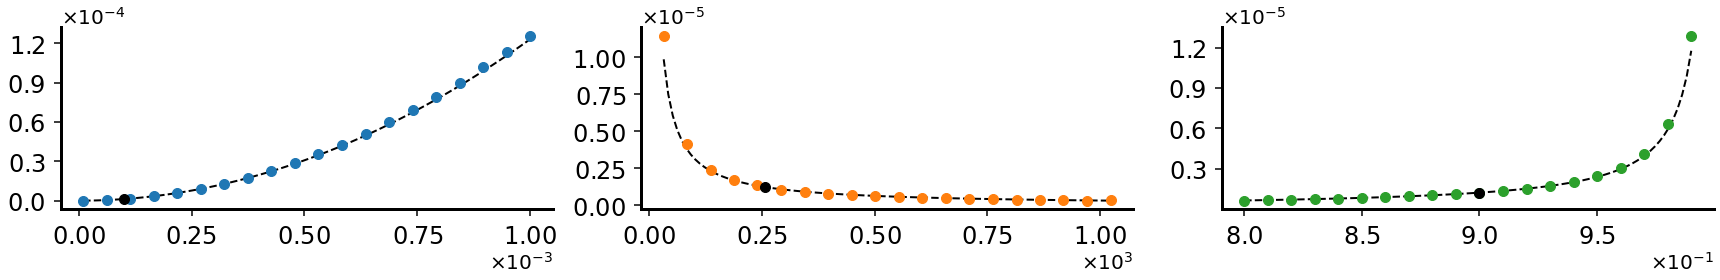

In [160]:
nrows = 1
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(8 * ncols, 4 * nrows))
lr = 0.0001
wd = 0.0001
bs = 256
momentum = 0.9
lrs = np.linspace(1e-3, 1e-5, 20)
bss = np.linspace(32, 1024, 20)
bss = np.array([int(bs) for bs in bss])
moms = np.linspace(0.8, 0.99, 20)

lr_= f"{lr:1.2e}".replace("-","n").replace(".","d")
wd_= f"{wd:1.0e}".replace("-","n") if wd > 0 else "0"
mom_ = f"{momentum}".replace(".", "")
experiment = "lean_sweep_3"
expid = f"res18_lr{lr_}_wd{wd_}_mom{mom_}_bs{bs}"
d = dd.io.load(f"{CACHE_PATH}/{experiment}/{expid}/cache/loss_diff_from_ckpt.h5", "/loss_diff")

default_vel_norm = (lr**2)*d["vel_norm"][-1]
y_theory = lr**2 / (bs * (1-momentum**2))
sigma_tr_H = default_vel_norm / y_theory
axes[0].scatter(lr, (lr**2)*d["vel_norm"][-1], color="k", s=100, zorder=300)
axes[1].scatter(bs, (lr**2)*d["vel_norm"][-1], color="k", s=100, zorder=300)
axes[2].scatter(momentum, (lr**2)*d["vel_norm"][-1], color="k", s=100, zorder=300)

ax = axes[0]
axes[0].scatter(lrs, lr_deltas, color=plt.cm.tab10(0), s=100, zorder=200)
lrs = np.linspace(min(lrs), max(lrs), 100)
y_theory = lrs**2 / (bs * (1-momentum**2))*sigma_tr_H 
ax.plot(lrs, y_theory, "k--", lw=2)
style_axes(ax)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.ticklabel_format(axis="x", style="scientific", scilimits=(0,1), useMathText=True)
ax.ticklabel_format(axis="y", style="scientific", scilimits=(0,1), useMathText=True)
ax.yaxis.offsetText.set_fontsize(20)

ax = axes[1]
ax.scatter(bss, bs_deltas, color=plt.cm.tab10(1), s=100, zorder=200)
bss = np.linspace(min(bss), max(bss), 100)
y_theory = lr**2 / (bss * (1-momentum**2))*sigma_tr_H 
ax.plot(bss, y_theory, "k--", lw=2)
style_axes(ax)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
#ax.ticklabel_format(axis="x", style="scientific", scilimits=(0,1), useMathText=True)
ax.ticklabel_format(axis="y", style="scientific", scilimits=(0,1), useMathText=True)
ax.yaxis.offsetText.set_fontsize(20)


ax = axes[2]
ax.scatter(moms, mom_deltas, color=plt.cm.tab10(2), s=100, zorder=200)
moms_ = np.linspace(min(moms), max(moms), 100)
y_theory = lr**2 / (bs * (1-moms_**2))*sigma_tr_H
ax.plot(moms_, y_theory, "k--", lw=2)
style_axes(ax)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
#ax.ticklabel_format(axis="x", style="scientific", scilimits=(0,1), useMathText=True)
ax.ticklabel_format(axis="y", style="scientific", scilimits=(0,1), useMathText=True)
ax.yaxis.offsetText.set_fontsize(20)

plt.tight_layout()
plt.savefig("hyperparam_relation.pdf")

/home/jvrsgsty/py3/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in log
/home/jvrsgsty/py3/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in log


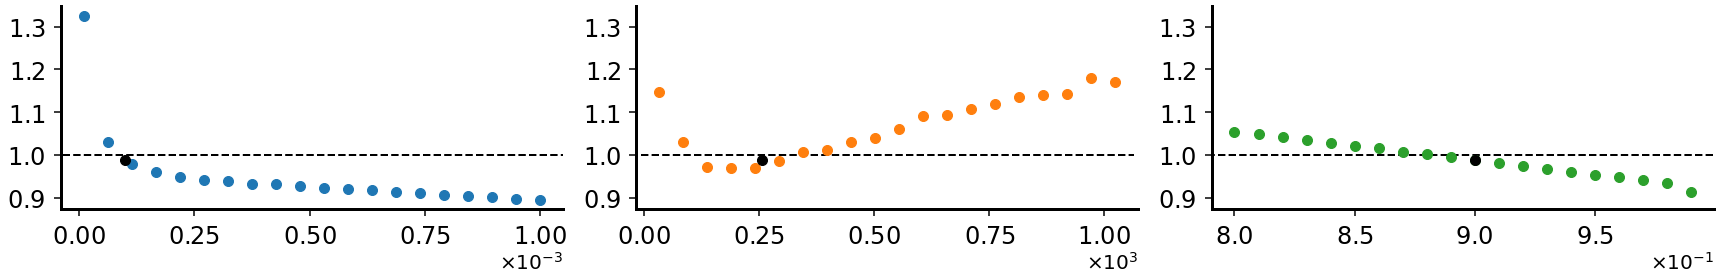

In [161]:
nrows = 1
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(8 * ncols, 4 * nrows), sharey=True)
lr = 0.0001
wd = 0.0001
bs = 256
momentum = 0.9
lrs = np.linspace(1e-3, 1e-5, 20)
bss = np.linspace(32, 1024, 20)
bss = np.array([int(bs) for bs in bss])
moms = np.linspace(0.8, 0.99, 20)

lr_= f"{lr:1.2e}".replace("-","n").replace(".","d")
wd_= f"{wd:1.0e}".replace("-","n") if wd > 0 else "0"
mom_ = f"{momentum}".replace(".", "")
experiment = "lean_sweep_3"
expid = f"res18_lr{lr_}_wd{wd_}_mom{mom_}_bs{bs}"
d = dd.io.load(f"{CACHE_PATH}/{experiment}/{expid}/cache/performance_from_ckpt.h5", "/performance")
steps = d["step"][2:-1]
default_performance = d["test_loss"][-1]
d = dd.io.load(f"{CACHE_PATH}/{experiment}/{expid}/cache/dist_from_start_from_ckpt.h5", "/dist_from_start")
x = steps
y = d["dist_from_start"]**2
x = np.log(x[1:])
y = np.log(y[1:])
x_ = x#[len(x)//2:]
y_ = y#[len(y)//2:]
model = LinearRegression()
model.fit(x_[:, np.newaxis], y_)
default_intercept = model.intercept_
default_coef = model.coef_[0]

axes[0].scatter(lr, default_coef, color="k", s=100, zorder=300)
axes[1].scatter(bs, default_coef, color="k", s=100, zorder=300)
axes[2].scatter(momentum, default_coef, color="k", s=100, zorder=300)

lr_intercept_theory = np.log(lr**2)
lr_intercept_const = default_intercept - lr_intercept_theory

lr_coef_theory = 1/lr
lr_coef_const = default_coef / lr_coef_theory

bs_intercept_theory = np.log(1 / bs)
bs_intercept_const = default_intercept - bs_intercept_theory

mom_intercept_theory = np.log(1 / (1-momentum**2))
mom_intercept_const = default_intercept - mom_intercept_theory

mom_coef_theory = (1-momentum)/(1+momentum)
mom_coef_const = default_coef - mom_coef_theory

ax = axes[0]
#ax2 = ax.twinx()
ax.scatter(lrs, lr_Delta_slopes, color=plt.cm.tab20(0), s=100, marker="o", zorder=200)
#ax2.scatter(lrs, lr_Delta_intercepts, color=plt.cm.tab20(1), s=100, marker="s", zorder=200)
lrs = np.linspace(min(lrs)-1, max(lrs)+1, 100)
xlim = ax.get_xlim()
ax.plot(lrs, 1*np.ones_like(lrs), "k--", lw=2)
ax.set_xlim(xlim)
y_theory = 1/lrs * lr_coef_const
y_theory = y_theory
#ax.plot(lrs, y_theory, "r--", lw=2)
y_theory = np.log(lrs**2) + lr_intercept_const 
#ax2.plot(lrs, y_theory, "k--", lw=2)
style_axes(ax)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.ticklabel_format(axis="x", style="scientific", scilimits=(0,1), useMathText=True)
ax.ticklabel_format(axis="y", style="scientific", scilimits=(0,1), useMathText=True)
ax.yaxis.offsetText.set_fontsize(20)

ax = axes[1]
#ax2 = ax.twinx()
ax.scatter(bss, bs_Delta_slopes, color=plt.cm.tab20(2), s=100, marker="o", zorder=200)
#ax2.scatter(bss, bs_Delta_intercepts, color=plt.cm.tab20(3), s=100, marker="s", zorder=200)
xlim = ax.get_xlim()
bss = np.linspace(min(bss)-40, max(bss)+40, 100)
ax.set_xlim(xlim)
ax.plot(bss, 1*np.ones_like(bss), "k--", lw=2)
y_theory = np.log(1 / bss) + bs_intercept_const
#ax2.plot(bss, y_theory, "k--", lw=2)
style_axes(ax)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
#ax.ticklabel_format(axis="x", style="scientific", scilimits=(0,1), useMathText=True)
ax.ticklabel_format(axis="y", style="scientific", scilimits=(0,1), useMathText=True)
ax.yaxis.offsetText.set_fontsize(20)


ax = axes[2]
#ax2 = ax.twinx()
ax.scatter(moms, mom_Delta_slopes, color=plt.cm.tab20(4), s=100, marker="o", zorder=200)
#ax2.scatter(moms, mom_Delta_intercepts, color=plt.cm.tab20(5), s=100, marker="s", zorder=200)
moms_ = np.linspace(min(moms)-1, max(moms)+1, 100)
xlim = ax.get_xlim()
ax.plot(moms_, 1*np.ones_like(moms_), "k--", lw=2)

y_theory = (1-moms_) / (1+moms_) + mom_coef_const
y_theory = y_theory
#ax.plot(moms_, y_theory, "r--", lw=2)
ax.set_xlim(xlim)
y_theory = np.log(1 / (1-moms_**2)) + mom_intercept_const
#ax2.plot(moms_, y_theory, "k--", lw=2)
style_axes(ax)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
#ax.ticklabel_format(axis="x", style="scientific", scilimits=(0,1), useMathText=True)
ax.ticklabel_format(axis="y", style="scientific", scilimits=(0,1), useMathText=True)
ax.yaxis.offsetText.set_fontsize(20)

plt.tight_layout()
plt.savefig("diffusion_coef_sweeep.pdf")

# Figure 8

In [29]:
lrs = [1e-4, 1e-3, 1e-5]
wds = [1e-4]
bss = [128, 256, 512]
momentums = [0.8, 0.9, 0.99]
expids = []
for lr,wd,bs,momentum in itertools.product(lrs, wds, bss, momentums):
    lr_= f"{lr:1.0e}".replace("-","n")
    wd_= f"{wd:1.0e}".replace("-","n") if wd > 0 else "0"
    mom_ = f"{momentum}".replace(".", "")
    expid = f"res18_lr{lr_}_wd{wd_}_mom{mom_}_bs{bs}"
    expids.append(expid)
expids_ = [e for e in expids if "mom08" not in e]

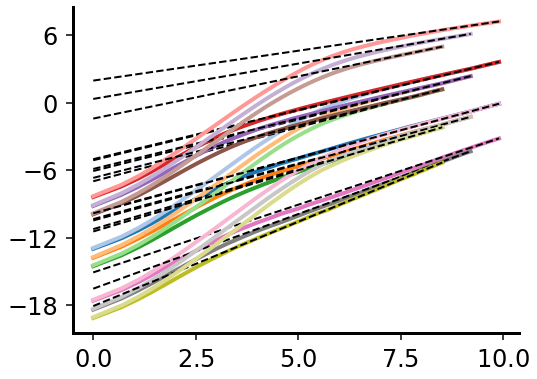

In [30]:
# sampling on consecutive steps, 5 times an epoch
nrows = 1
ncols = 1
fig, axes = plt.subplots(nrows, ncols, figsize=(8 * ncols, 6 * nrows))
k = 0
CACHE_PATH = "/mnt/fs6/jvrsgsty/neural-mechanics/jv_neural_mechanics"
experiment = "lean_sweep"

expid = expids[4]
print(expid)
bs = int(expid.split("bs")[1])
lr = float(expid.split("lr")[1].split("_")[0].replace("n","-"))
d = dd.io.load(f"{CACHE_PATH}/{experiment}/{expid}/cache/loss_diff_from_ckpt.h5", "/loss_diff")
y = (lr**2)*d["vel_norm"][k:]**2
base_mean = np.mean(y)

for i,expid in enumerate(expids_):
    bs = int(expid.split("bs")[1])
    lr = float(expid.split("lr")[1].split("_")[0].replace("n","-"))
    mom = float(expid.split("mom")[1].split("_")[0].replace("0","0."))
    
    ax = axes
    d = dd.io.load(f"{CACHE_PATH}/{experiment}/{expid}/cache/dist_from_start_from_ckpt.h5", "/dist_from_start")
    x = np.arange(0,len(d["dist_from_start"]))
    y = d["dist_from_start"]**2
    x = np.log(x[1:])#[k:]
    #x = np.log(np.arange(1, -k+1))
    y = np.log(y[1:])#[k:]
    
    x_ = x[len(x)//2:]
    y_ = y[len(y)//2:]
    
    model = LinearRegression()
    model.fit(x_[:, np.newaxis], y_)

    x_fit = np.linspace(min(x), max(x), 100)
    y_fit = model.predict(x_fit[:, np.newaxis])
    
    ax.plot(x, y, 
                 label=f"({lr}, {bs}, {mom}) c: {model.coef_[0]:1.3f}", color=plt.cm.tab20(i%20),
                 lw=4)
    ax.plot(x_fit, y_fit, "k--",
                 lw=2)
    #ax.legend()
    style_axes(ax)
plt.savefig("delta-global-sweep.pdf")

# Previous Figure 7

base res18_lr1en04_wd1en04_mom09_bs256


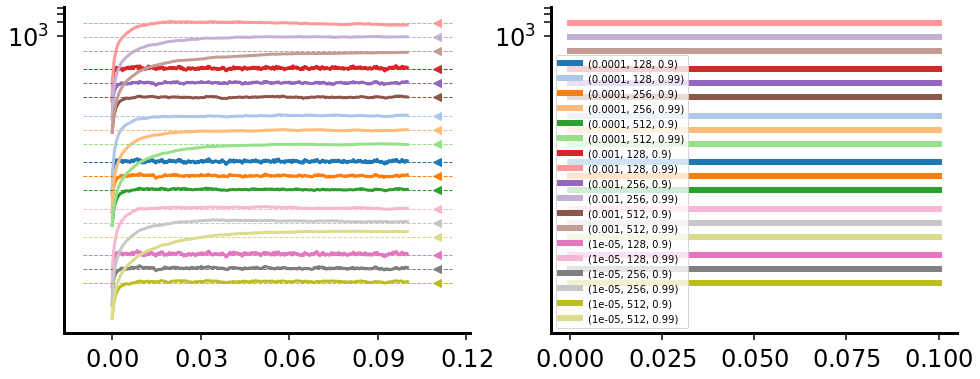

In [31]:
# sampling on consecutive steps, 5 times an epoch
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(8 * ncols, 6 * nrows), sharey=True)
k = 0
CACHE_PATH = "/mnt/fs6/jvrsgsty/neural-mechanics/jv_neural_mechanics"
experiment = "lean_sweep"

expid = expids[4]
print("base", expid)
bs = int(expid.split("bs")[1])
lr = float(expid.split("lr")[1].split("_")[0].replace("n","-"))
mom = float(expid.split("mom")[1].split("_")[0].replace("0","0."))
d = dd.io.load(f"{CACHE_PATH}/{experiment}/{expid}/cache/loss_diff_from_ckpt.h5", "/loss_diff")
y = (lr**2)*d["vel_norm"][k:]
y_theory_base = lr**2 / (bs * (1-mom**2))
base_mean = np.mean(y)
min_y = 1000
max_y = 0
expids_ = [e for e in expids if "mom08" not in e]
for i,expid in enumerate(expids_):
    bs = int(expid.split("bs")[1])
    lr = float(expid.split("lr")[1].split("_")[0].replace("n","-"))
    mom = float(expid.split("mom")[1].split("_")[0].replace("0","0."))
    d = dd.io.load(f"{CACHE_PATH}/{experiment}/{expid}/cache/loss_diff_from_ckpt.h5", "/loss_diff")
    lr_idx = i//9
    bs_idx = (i%9) // 3 
    mom_idx = i%3
    
    colors = [0,1,2]
    styles = [":", "--", "-"]
    opacity = [1, 0.8, 0.5]
    
    #plot_kwargs = {"color": plt.cm.tab120(colors[lr_idx]),"ls": styles[bs_idx], 
    #               "alpha": opacity[mom_idx], "lw": 3, }
    plot_kwargs = {"color": plt.cm.tab20(i), "lw": 3, }
    
    x = np.linspace(0,0.1,len(d["vel_norm"][k:])//2//10)
    y = ((lr**2)*d["vel_norm"][:len(d["vel_norm"])//2//10]) / base_mean
    min_y = min(min_y, min(y))
    max_y = max(max_y, max(y))
    y_theory = lr**2 / (bs * (1-mom**2)) / y_theory_base

    #plot_moving_average(axes[0], x, y, w=20, **plot_kwargs)
    axes[0].plot(x, y, label=f"({lr}, {bs}, {mom})", **plot_kwargs)
    #axes[1].set_ylim([0, 1])
    #axes[1].set_title("Cifar100 |theta_{k+1} - theta_{k}|_2^2")
    #axes[1].set_ylabel("|theta_{k+1} - theta_{k}|_2^2")
    #axes[1].set_xlabel("Train epoch")
    axes[0].set_yscale("log")
    
    #axes[0].plot(np.linspace(-0.05,1.15,2), [23]*2, "k", lw=1)
    #axes[0].plot(np.linspace(-0.05,1.15,2), [0.24]*2, "k", lw=1)
    plot_kwargs["lw"] = 1
    axes[0].plot(np.linspace(-0.01,0.115,2), [y_theory]*2, "--", **plot_kwargs)
    plot_kwargs["lw"] = 6
    axes[0].plot(0.11, y_theory, "<", markersize=8, **plot_kwargs)
    
    style_axes(axes[0])
    
    axes[1].plot(x, y_theory*np.ones_like(x), label=f"({lr}, {bs}, {mom})", **plot_kwargs)
    axes[1].set_yscale("log")
    style_axes(axes[1])
    axes[1].legend()
#axes[0].plot([2.1]*2, np.linspace(min_y, max_y, 2), "k--")
plt.savefig("delta-local-sweep.pdf")

# TODO: labels in legend BS, LR, MOM
# TODO: highlight the default hyperparams